# Incremental Algorithms Problem Set (50 points)

In this problem set, you will implement the ARA* algorithm, an anytime heuristic search that tunes its performance bound based on available search time. The algorithm begins by finding a suboptimal solution quickly using a loose bound and then progressively tightens the bound until time runs out. With enough time, it finds a provably optimal solution. In addition, while improving its bound, ARA* reuses previous search efforts, which makes it significantly more efficient.

Make sure you load the dependencies below.

In [25]:
%matplotlib widget

from collections import defaultdict
import numpy as np

from utils import State, ARAStar_State, ARAStar_Plotter, GRAPH_LARGE, GRAPH_SMALL

# Conceptual Questions

## Problem 1 (2 pts) 

Why might we prefer to find a suboptimal solution over an optimal solution? Can you name a hypothetical example in which this would be the case.
<br/>
<div class="alert alert-info">Please type your answer below.</div>

Finding an optimal solution is often very time consuming and thus, is infeasible for real world problems, which often have a limited amount of time for deliberation. A suboptimal solution can be found significantly faster. A suboptimal solution might be preferred, for example, when trying to reroute a rover on Mars in the presence of a dust storm--there isn't enough time to find an optimal path.

## Problem 2 (2 pts) 
In the following figure, the left three columns correspond to A* searches with decreasing $\epsilon$ and the right three columns correspond to ARA* search iterations with decreasing $\epsilon$. The shaded cells represent cells that have been expanded. Why are there fewer cells expanded in the ARA* algorithm? 
<img src="ara_star_iterations.png" />
<br/>
<div class="alert alert-info">Please type your answer below.</div>

# Specification of ARA* Planner

We have created a class called `ARAStar_Planner` with several data structures and utility methods that are helpful in performing the ARA* algorithm. We have also provided some additional utilies for serializing the state of the algorithm for visualization purposes. We recommend you take a look at `ara_star.py` to understand how these methods work. 

ARA* reuses the results of the previous search trees to save computation, which A* does not do. 

Add some intro about ARA*, how it works, what it's trying to solve, etc. Some graphics pulled from the slides or paper or online would be nice. Follow the recommendations on the advanced lecture assignment page. Include something about the effect changing epsilon has on the search

Add some instructions like 'our ARA* implementation is below, you'll need to fill out the following methods: initialize(), improve_path(), calc_epsilon_prime(), run() (include a brief description for each method). we've included testing code for each method so you can implement them one at a time, but the tests build on each other so make sure to go in order'.

Something like 'pseudocode for each of the methods you'll need to implement is included here. it's based on the pseudocode from the original ARA* paper, with some additions to make it easier to visualize and test our outputs.' And then include the pseudocode images, ideally one next to the other.

In [87]:
class ARAStar_Planner:
    """The ARA* planner with needed utilities, along with some additional
    utilities for serializing the state of the algorithm for visualization
    and testing purposes.

    Attributes
    ----------
    graph : np.ndarray, (n x m)
        the graph being searched through, see __init__ for format requirements.
    start, goal : State
        start and goal states in the graph
    epsilon : float
        inflation factor for the heuristic function
    stepsize : float
        amount to decrease epsilon by each iteration of ARA*
    g : dict[State, float]
        dict of costs from the start State to a given State within the graph
    OPEN : dict[State: float]
        dict of locally inconsistent States to respective fvalues, used as
        a priority queue for ARA* search
    CLOSED : set[State]
        set of States which have been expanded
    INCONS : set[State]
        set of locally inconsistent States which have been previously expanded
    PARENTS : dict[State, State]
        dict mapping each expanded State to its predecessor State in the graph
    alg_history : dict[float, List[ARAStar_State]]
        dict mapping an epsilon value to a list of ARAStar_State objects,
        which recreate the state of the algoritm as it progressed through
        its search.
    paths_found : dict[float, List[State]]
        dict mapping epsilon values to the final paths returned for that
        epsilon. Path is represented as a list of States, start to goal.
    """
    def __init__(self, graph: np.ndarray, start: State,
                 goal: State, epsilon: float = 3.0,
                 stepsize: float = 0.4) -> None:
        '''
        Parameters
        ----------
            graph : np.ndarray
                NumPy array representing the graph to search through. Should
                comprise of only 0s and 1s, with 0s representing free space
                and 1s representing obstacles.
            start, goal : State
                start and goal states for the search.
            epsilon : float
                initial inflation factor for the heuristic function
            stepsize : float
                amount to decrease epsilon by each iteration of ARA*
        '''
        self.graph = graph
        self.start = start
        self.goal = goal
        self.epsilon = epsilon
        self.stepsize = stepsize

        self.g = {}
        self.OPEN = {}
        self.CLOSED = set()
        self.INCONS = set()
        self.PARENTS = {}

        self.alg_history = defaultdict(list)
        self.paths_found = {}

    def h(self, state: State) -> int:
        """Euclidean heuristic between goal and state."""
        return np.hypot(self.goal.x - state.x, self.goal.y - state.y)
        # return max(abs(state.x - self.goal.x), abs(state.y - self.goal.y))

    def f(self, state: State) -> float:
        """Combined inflated heuristic."""
        return self.g[state] + self.epsilon * self.h(state)

    def is_clear(self, state: State) -> bool:
        """Returns True if given state does not collide with an obstacle in the graph,
        False otherwise."""
        return self.graph[state] == 0

    def is_obstacle(self, state: State):
        """Returns True if given state collides with an obstacle in the graph,
        False otherwise."""
        return self.graph[state] != 0

    def valid_state(self, state: State) -> bool:
        """Returns True if given state is within bounds of graph and does not
        collide with an obstacle, False otherwise."""
        x, y = state
        x_bound, y_bound = self.graph.shape
        return 0 <= x < x_bound and 0 <= y < y_bound and self.is_clear(state)

    def neighbors(self, state: State) -> list[State]:
        """Returns list of neighbors of the given state which are within the bounds
        of the 8-connected graph and which do not collide with obstacles."""
        x, y = state
        n = [
            (x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
            (x, y - 1), (x, y + 1),
            (x + 1, y - 1), (x + 1, y), (x + 1, y + 1),
        ]
        return [State(*s) for s in n if self.valid_state(s)]

    def cost(self, state1: State, state2: State) -> float:
        """Cost of traversal between two states. Infinite if states are not
        neighbors, else Euclidean distance."""
        if state2 not in self.neighbors(state1):
            return np.inf

        return np.hypot(state2.x - state1.x, state2.y - state1.y)

    def get_next_state(self) -> State:
        """Returns the state from OPEN with the lowest f value, which should
        be expanded next, or None if OPEN is empty."""
        if not self.OPEN:
            return None

        lowest_f = min(self.OPEN.values())
        next_states = {state for state, f in self.OPEN.items() if f == lowest_f}
        return min(next_states)  # breaks ties between states

    def extract_path(self, final_state: State = None) -> list[State]:
        """From PARENTS mapping, returns path to final_state as a list
        of States. If final_state is None, defaults to goal state."""
        if final_state is None:
            final_state = self.goal

        if final_state not in self.PARENTS:  # path not found yet
            return None

        s = final_state  # rename within loop
        path = [s]
        while True:
            s = self.PARENTS[s]
            path.append(s)

            if s == self.start:
                break

        path.reverse()
        return path

    def publish_path(self):
        """Saves current value of epsilon and current path to set of paths found."""
        self.paths_found[self.epsilon] = self.extract_path()

    def save_alg_state(self, current_state: State):
        """Saves current path and values of OPEN, CLOSED, and INCONS states
        to alg history for use in testing and plotting."""
        self.alg_history[self.epsilon].append(ARAStar_State(
                self.OPEN.copy(),
                self.CLOSED.copy(),
                self.INCONS.copy(),
                self.extract_path(current_state)
            ))

    #* student implemented
    def initialize(self):
        ### BEGIN SOLUTION ###
        self.OPEN = {}
        self.CLOSED = set()
        self.INCONS = set()
        self.PARENTS = {}
        self.alg_history = defaultdict(list)
        self.paths_found = {}
        
        self.g[self.goal] = float('inf')
        self.g[self.start] = 0
        self.OPEN[self.start] = self.f(self.start) 
        self.PARENTS[self.start] = self.start
        ### END SOLUTION ###
        
    def get_best_vertex(self, pq):
        best_vertex, best_f = None, float('inf')
        for vertex in pq.keys():
            if self.f(vertex) < best_f:
                best_vertex = vertex
                best_f = self.f(vertex)
        return best_vertex, best_f

    #* student implemented
    def improve_path(self):
        ### BEGIN SOLUTION ###
        self.save_alg_state(self.start)
        best_vertex, best_f = self.get_best_vertex(self.OPEN)
        while self.f(self.goal) > best_f:
            s = best_vertex
            del self.OPEN[s]
            self.CLOSED.add(s)
            for successor in self.neighbors(s):
                if successor not in self.g:
                    self.g[successor] = float('inf')
                if self.g[successor] > self.g[s] + self.cost(s, successor):
                    self.g[successor] = self.g[s] + self.cost(s, successor)
                    self.PARENTS[successor] = s
                    if successor not in self.CLOSED:
                        self.OPEN[successor] = self.f(successor)
                    else:
                        self.INCONS.add(successor)
            self.save_alg_state(s)
            best_vertex, best_f = self.get_best_vertex(self.OPEN)
        ### END SOLUTION ###

    #* student implemented
    def calc_epsilon_prime(self):
        ### BEGIN SOLUTION ###
        best_s, best_val = None, float('inf')
        for s in self.OPEN.keys():
            if self.g[s] + self.h(s) < best_val:
                best_s = s
                best_val = self.g[s] + self.h(s)
        for s in self.INCONS:
            if self.g[s] + self.h(s) < best_val:
                best_s = s
                best_val = self.g[s] + self.h(s)
        
        return min(self.epsilon, self.g[self.goal] / best_val) 
        ### END SOLUTION ###

    #* student implemented
    def run(self):
        ### BEGIN SOLUTION ###
        self.initialize()
        self.improve_path()
        _epsilon = self.calc_epsilon_prime()
        self.publish_path()
        while _epsilon > 1:
            self.epsilon -= self.stepsize
            for s in self.INCONS:
                self.OPEN[s] = self.f(s)
            self.INCONS = set()
            self.CLOSED = set()
            self.improve_path()
            _epsilon = self.calc_epsilon_prime()
            self.publish_path()
        ### END SOLUTION ###

In [88]:
# Raul: finish test for initialize() 10 pts
# testers: run this cell after implementing initialize

planner = ARAStar_Planner(GRAPH_SMALL, State(0, 0), State(6, 5), 2.5, stepsize=1)
planner.initialize()
print(planner.g)
print(planner.OPEN)
print(planner.PARENTS)
assert not planner.CLOSED
assert not planner.INCONS
assert not planner.alg_history
assert not planner.paths_found

planner = ARAStar_Planner(GRAPH_LARGE, State(24, 4), State(4, 44), 1.5, .2)
planner.initialize()
print(planner.OPEN)

{State(x=6, y=5): inf, State(x=0, y=0): 0}
{State(x=0, y=0): 19.525624189766635}
{State(x=0, y=0): State(x=0, y=0)}
{State(x=24, y=4): 67.0820393249937}


In [89]:
# Raul: write test for improve_path() 10 pts
# testers: run this cell after implementing improve_path

planner = ARAStar_Planner(GRAPH_SMALL, State(0, 0), State(6, 5), 2.5, stepsize=1)
planner.initialize()
planner.improve_path()
planner.publish_path()
from pprint import pprint
pprint(planner.alg_history)
pprint(planner.paths_found)

defaultdict(<class 'list'>,
            {2.5: [ARAStar_State(OPEN={State(x=0, y=0): 19.525624189766635},
                                 CLOSED=set(),
                                 INCONS=set(),
                                 current_path=[State(x=0, y=0),
                                               State(x=0, y=0)]),
                   ARAStar_State(OPEN={State(x=0, y=1): 19.027756377319946,
                                       State(x=1, y=1): 17.422024155955217},
                                 CLOSED={State(x=0, y=0)},
                                 INCONS=set(),
                                 current_path=[State(x=0, y=0),
                                               State(x=0, y=0)]),
                   ARAStar_State(OPEN={State(x=0, y=1): 19.027756377319946,
                                       State(x=0, y=2): 19.598936955994617,
                                       State(x=2, y=1): 16.556349186104047},
                                 CLOSED={State(x=1, y

In [90]:
# Raul: write test for calc_epsilon_prime() 10 pts
# testers: run this cell after implementing calc_epsilon_prime

planner = ARAStar_Planner(GRAPH_SMALL, State(0, 0), State(6, 5), 2.5, stepsize=1)
planner.initialize()
planner.improve_path()
print(planner.calc_epsilon_prime())

planner = ARAStar_Planner(GRAPH_LARGE, State(24, 4), State(4, 44), 1.5, .2)
planner.initialize()
planner.improve_path()
print(planner.calc_epsilon_prime())

1.6423228537944068
1.2514705177523118


In [91]:
# Raul: write test for run() 10 pts
# testers: run this cell after implementing run

planner = ARAStar_Planner(GRAPH_LARGE, State(24, 4), State(4, 44), 1.5, .2)
planner.run()
from pprint import pprint
pprint(planner.paths_found)

{0.9000000000000001: [State(x=24, y=4),
                      State(x=24, y=5),
                      State(x=24, y=6),
                      State(x=24, y=7),
                      State(x=25, y=8),
                      State(x=26, y=9),
                      State(x=27, y=10),
                      State(x=27, y=11),
                      State(x=27, y=12),
                      State(x=27, y=13),
                      State(x=27, y=14),
                      State(x=27, y=15),
                      State(x=27, y=16),
                      State(x=27, y=17),
                      State(x=27, y=18),
                      State(x=28, y=19),
                      State(x=27, y=20),
                      State(x=26, y=21),
                      State(x=25, y=22),
                      State(x=24, y=23),
                      State(x=23, y=24),
                      State(x=22, y=25),
                      State(x=21, y=26),
                      State(x=20, y=27),
                      

Now that we've verified our implementation, let's see how it works in action, by visualizing how the search progresses along a graph with a two different potential paths for different values of $\epsilon$

In [92]:
EPSILON = 2.5
START = State(0, 0)
GOAL = State(6, 5)

planner = ARAStar_Planner(GRAPH_SMALL, START, GOAL, EPSILON, stepsize=1)
plotter = ARAStar_Plotter(GRAPH_SMALL, START, GOAL)
planner.run()

In [95]:
plotter.plot_episode(2.5, planner.alg_history[2.5])

In [97]:
plotter.plot_episode(1.5, planner.alg_history[1.5])


{2.5: [State(x=0, y=0), State(x=1, y=1), State(x=2, y=1), State(x=3, y=1), State(x=4, y=0), State(x=5, y=1), State(x=5, y=2), State(x=4, y=3), State(x=3, y=4), State(x=4, y=5), State(x=5, y=5), State(x=6, y=5)], 1.5: [State(x=0, y=0), State(x=0, y=1), State(x=0, y=2), State(x=0, y=3), State(x=0, y=4), State(x=1, y=5), State(x=2, y=5), State(x=3, y=5), State(x=4, y=5), State(x=5, y=5), State(x=6, y=5)]}


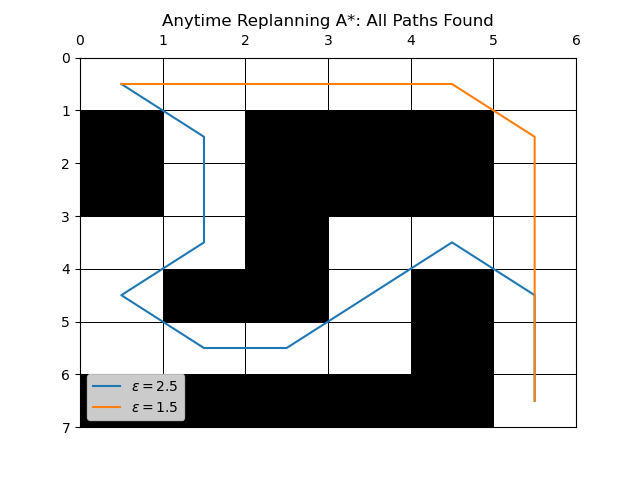

In [96]:
print(planner.paths_found)
plotter.plot_paths_found(planner.paths_found)

Add some notes about how the graphs should look like, explain how widget works

## Applying ARA* to Larger Graphs with Multiple Branches (10 pts)

Now lets try applying our planner to larger regions where there might be many different paths we can take.

In [98]:
EPSILON = 1.5
START = State(24, 4)
GOAL = State(4, 44)

planner = ARAStar_Planner(GRAPH_LARGE, START, GOAL, EPSILON, stepsize=0.2)
plotter = ARAStar_Plotter(GRAPH_LARGE, START, GOAL)
planner.run()

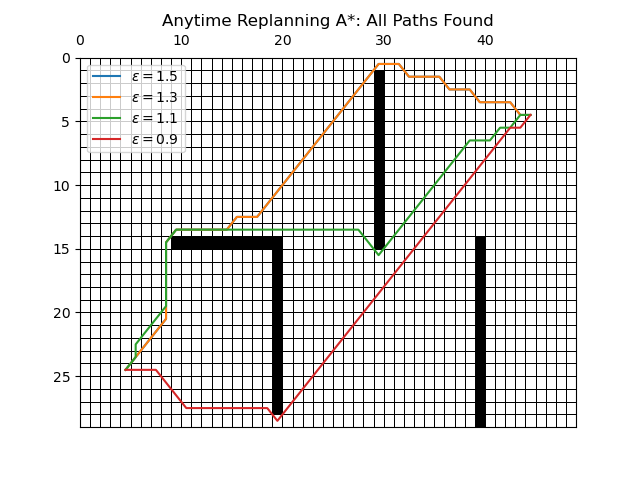

In [99]:
plotter.plot_paths_found(planner.paths_found)

Why does the graph look like this? How does eps changing affect the path?

As epsilon decreases, the length of the shortest path decreases as well because the start distances get prioritized, which factor in the location of obstacles, as opposed to the heuristic values, which don't factor in the location of obstacles. Thus, the path at epsilon = 0.9 avoids most of the obstacles while the path with epsilon = 1.3 has to navigate around two of the obstacles. 